In [46]:
import pandas as pd
from datetime import datetime, timedelta
from scipy import integrate, optimize
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [47]:
# data preprocessing
data = pd.read_csv('owid-covid-data.csv')
country = 'Turkey'
country_data = data[data.location == country]
country_data = country_data[(country_data['total_cases'] > 0)]
country_data

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
14613,TUR,Turkey,2020-03-12,1,1,0,0,0.012,0.012,0.000,0.000,NaN,NaN,NaN,NaN,NaN
14614,TUR,Turkey,2020-03-13,2,1,0,0,0.024,0.012,0.000,0.000,NaN,NaN,NaN,NaN,NaN
14615,TUR,Turkey,2020-03-16,18,16,0,0,0.213,0.190,0.000,0.000,NaN,NaN,NaN,NaN,NaN
14616,TUR,Turkey,2020-03-17,47,29,0,0,0.557,0.344,0.000,0.000,NaN,NaN,NaN,NaN,NaN
14617,TUR,Turkey,2020-03-18,98,51,0,0,1.162,0.605,0.000,0.000,10018.0,NaN,0.119,NaN,tests performed
14618,TUR,Turkey,2020-03-19,191,93,1,1,2.265,1.103,0.012,0.012,11999.0,1981.0,0.142,0.023,tests performed
14619,TUR,Turkey,2020-03-20,359,168,4,3,4.257,1.992,0.047,0.036,15655.0,3656.0,0.186,0.043,tests performed
14620,TUR,Turkey,2020-03-21,670,311,9,5,7.944,3.687,0.107,0.059,18607.0,2952.0,0.221,0.035,tests performed
14621,TUR,Turkey,2020-03-22,947,277,21,12,11.228,3.284,0.249,0.142,20345.0,1738.0,0.241,0.021,tests performed
14622,TUR,Turkey,2020-03-23,1236,289,30,9,14.655,3.427,0.356,0.107,24017.0,3672.0,0.285,0.044,tests performed


In [48]:
# population
pop_dict = {'United Kingdom': 67900000, 'Italy': 60500000, 'China': 1400050000, 'Turkey': 83200000}
pop = pop_dict[country]

# time interval
t_interval = np.arange(len(country_data))

# daily new cases
daily_new_cases = country_data['new_cases'].values

In [49]:
# evaluation meric
def evaluate(actual, predict):
    score = r2_score(actual, predict)
    return score

In [50]:
# SIR model
# initial values
I0 = daily_new_cases[0]
S0 = pop - I0
R0 = 0.0

# beta: contagion rate  gamma: recovery rate
def SIR(sir, t, beta, gamma):
    S, I, R = sir 
    dsdt = - beta * S * I / pop
    drdt = gamma * I
    didt = -(dsdt + drdt)
    return [dsdt, didt, drdt]

In [51]:
# solve SIR model
def solve_SIR(t, beta, gamma):
    return integrate.odeint(SIR, [S0, I0, R0], t, args=(beta, gamma))[:,1]
#     out = integrate.odeint(SIR, [S0, I0, R0], t, args=(beta, gamma))
#     i = out[:, 1]
#     start = i[0]
#     it = i[1:]
#     it_1 = i[:-1]
#     dif = it -  it_1
#     return np.append(start, dif)

# fit SIR model
popt_sir, pcov_sir = optimize.curve_fit(solve_SIR, t_interval, daily_new_cases, maxfev=2000)

In [52]:
# generate date
start_date = country_data.date.iloc[0]
days = len(t_interval)
date_interval = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
prediction = solve_SIR(t_interval, *popt_sir)

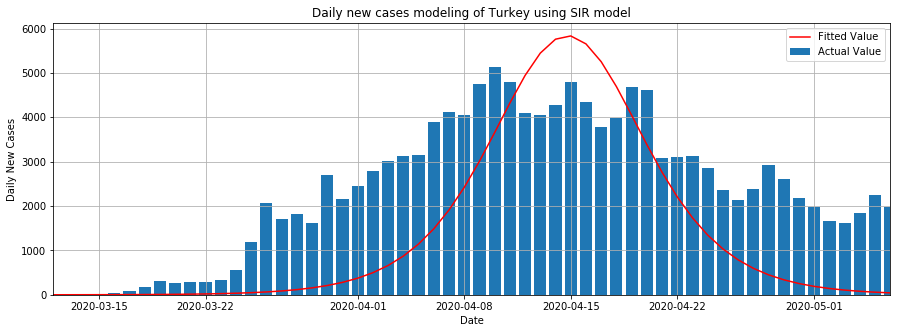

In [53]:
# visualize
plt.figure(0, figsize=(15, 5))
plt.plot(date_interval, prediction, c='r', label='Fitted Value')
plt.bar(date_interval, daily_new_cases, label='Actual Value')
plt.title('Daily new cases modeling of ' + country + ' using SIR model')
plt.ylabel('Daily New Cases')
plt.xlabel('Date')
plt.xlim(date_interval[0], date_interval[-1])
plt.grid()
plt.legend()
plt.savefig('single_stage/' + country + '_sir.png')
plt.show()

In [54]:
# evaluate
sir_score = evaluate(daily_new_cases, prediction[0:len(country_data.date)])
print(f'r2_score of SIR: {sir_score}')

r2_score of SIR: 0.05744868352527133
